In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import os 
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
import math
from lmfit import Model, Parameters
import matplotlib as mpl
from scipy import stats

mpl.rcParams['pdf.fonttype'] = 42


In [14]:
plt.rcParams.update({
    'font.size': 16,          # 默认字体大小
    'axes.titlesize': 16,     # 标题字体大小
    'axes.labelsize': 16,     # 坐标轴标签字体大小
    'xtick.labelsize': 33,    # x轴刻度标签字体大小
    'ytick.labelsize': 33,    # y轴刻度标签字体大小
    'legend.fontsize': 16     # 图例字体大小
})


# 数据导入

In [ ]:
df = pd.read_excel('../../data/cases by cities/滁州市逐周病例统计.xlsx')
df

,Date,Case
0,2023-01-01,0
1,2023-01-08,0
2,2023-01-15,0
3,2023-01-22,0
4,2023-01-29,0
...,...,...
260,2020-12-02,0
261,2020-12-09,0
262,2020-12-16,0
263,2020-12-23,0


In [4]:
import pandas as pd

# 假设你已经有一个名为 df 的 DataFrame
# 确保 'Date' 列是 datetime 类型
df['Date'] = pd.to_datetime(df['Date'])

# 获取所有年份
years = df['Date'].dt.year.unique()

# 创建每一年的 DataFrame
for year in years:
    globals()[f'df_{year}'] = df[df['Date'].dt.year == year]

# 现在你可以通过 df_2019、df_2020 等访问相应年份的数据

I_2019 = df_2019['Case']
I_2020 = df_2020['Case']
I_2021 = df_2021['Case']
I_2022 = df_2022['Case']
I_2023 = df_2023['Case']

In [5]:
I_2019.sum()

103

# 数据拟合

## 2023

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 84
    # data points      = 25
    # variables        = 4
    chi-square         = 410.232794
    reduced chi-square = 19.5348949
    Akaike info crit   = 77.9462241
    Bayesian info crit = 82.8217274
    R-squared          = 0.55401723
[[Variables]]
    beta0:  0.05418900 +/- 0.04337831 (80.05%) (init = 0.001)
    alpha:  1.82851023 +/- 5.49315236 (300.42%) (init = 2)
    T:      52 (fixed)
    S2_0:   83365.1191 +/- 170068.568 (204.00%) (init = 3000)
    S3_0:   1805.36619 +/- 4.6969e+09 (260162894.84%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta0, S2_0)  = -0.9951
    C(alpha, S3_0)  = +0.9657
    C(beta0, alpha) = -0.3479
    C(alpha, S2_0)  = +0.3113
    C(beta0, S3_0)  = -0.1451
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 172
    # data points      = 11
    # variab

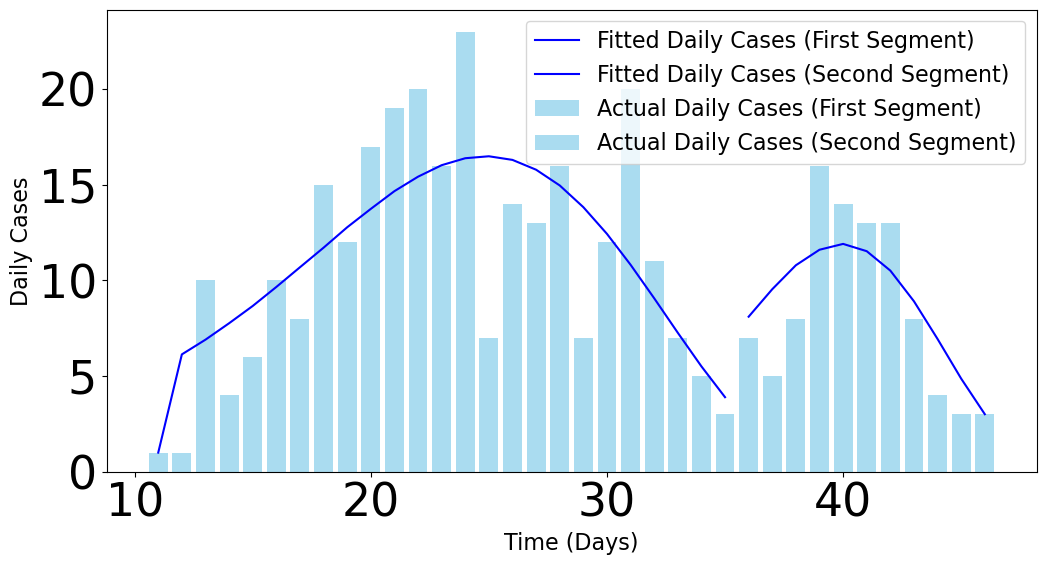

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters

# 定义 β 的季节性变化函数
def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))

# 定义 MMDM2 模型的微分方程
def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  # 人口总数
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  # 计算季节性β
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    # 微分方程
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  # 新发病例数

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]

# 提取每日新增病例数据
observed_cases_1 = I_2023[10:35].reset_index(drop=True).values  # 第一段数据
observed_cases_2 = I_2023[35:46].reset_index(drop=True).values  # 第二段数据
t_days_1 = np.arange(11, 36)  # 第一段48-236日
t_days_2 = np.arange(35, 47)  # 第二段拟合236-330日
t_days_3 = np.arange(36, 47)  # 画图用的第二段

# 定义模型包装函数，用于拟合数据
def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 4054999  # 直接代入初始值
    I1_0 = 1        # 直接代入初始值
    E1_0 = 0        # 直接代入初始值
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.00608
    dr1 = 0.00841
    κ = 1
    p = 0.043
    f = 0.0026954
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))

# 创建 lmfit 模型
model = Model(model_fit)

# 设置拟合参数及初始值和边界
params = Parameters()
params.add('beta0', value=0.001, min=0, max=1)  # β0 的范围设为 [0.01, 0.5]
params.add('alpha', value=2, min=-10, max=10)       # α 的范围设为 [-10, 10]
params.add('T', value=52, vary=False)               # T 固定为 52 周
params.add('S2_0', value=3000, min=1000, max=1e5)  # S2_0 的范围设为 [1000, 1e6]
params.add('S3_0', value=1000, min=1000, max=1e4)  # S3_0 的范围设为 [1000, 1e6]

# 使用 lmfit 进行拟合
result_1 = model.fit(observed_cases_1, params, t=t_days_1)

# 提取第一段拟合结果的最后状态，作为第二段的初始值
S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value

# 使用 MMDM_model 对第一段的各个仓室值进行求解
initial_state_segment1 = [
    4054999, 0, 0, 1, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.00608
dr1 = 0.00841
κ = 1
p = 0.043
f = 0.0026954
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))

# 提取第一段拟合结果的最后一个状态
final_state_segment1 = result_segment1.y[:, -1]

# 第二段数据的拟合
def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.00608
    dr1 = 0.00841
    κ = 1
    p = 0.043
    f = 0.0026954
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt

# 创建第二段拟合模型
model_segment2 = Model(model_fit_segment2)

# 设置第二段拟合参数
params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=52)  # 用拟合的T效果比较好
# params_segment2.add('T', value=52, vary=False) 

# 使用 lmfit 进行第二段拟合
result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)

# 输出拟合报告
print(result_1.fit_report())
print(result_2.fit_report())

# 绘制第一段和第二段拟合结果
plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

R_2023 的中位数: 5.236781131433068
R_2023 的中位数: 0.053391999894735795


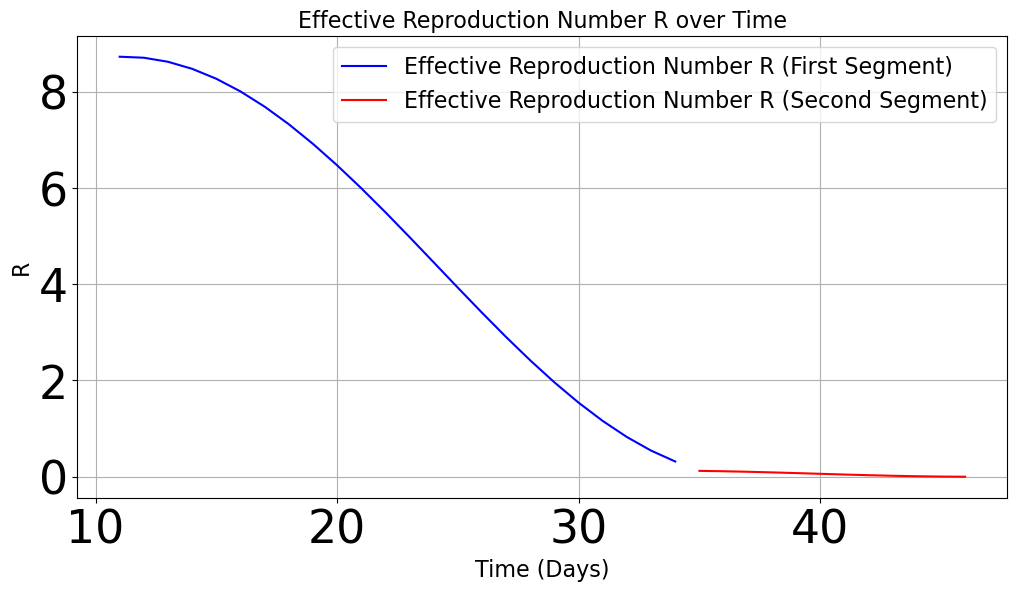

In [16]:
N1 = 4055000


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(11, 35)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics

# 如果 R_2023 是列表
median_R_1 = statistics.median(R_values_1)
median_R_2 = statistics.median(R_values_2)
print("R_2023 的中位数:", median_R_1)
print("R_2023 的中位数:", median_R_2)

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2023 = np.concatenate((result_1.best_fit, result_2.best_fit))

# 提取 I_2023[47:329] 的数据
observed_cases_2023 = I_2023[10:46].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2023# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2023  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# 计算MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')
# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 13.46823319922897
RMSE: 3.6699091540839226
R-squared: 0.5931180161262326
MAE: 2.8005275783451378
MAPE: 44.21804009969005%


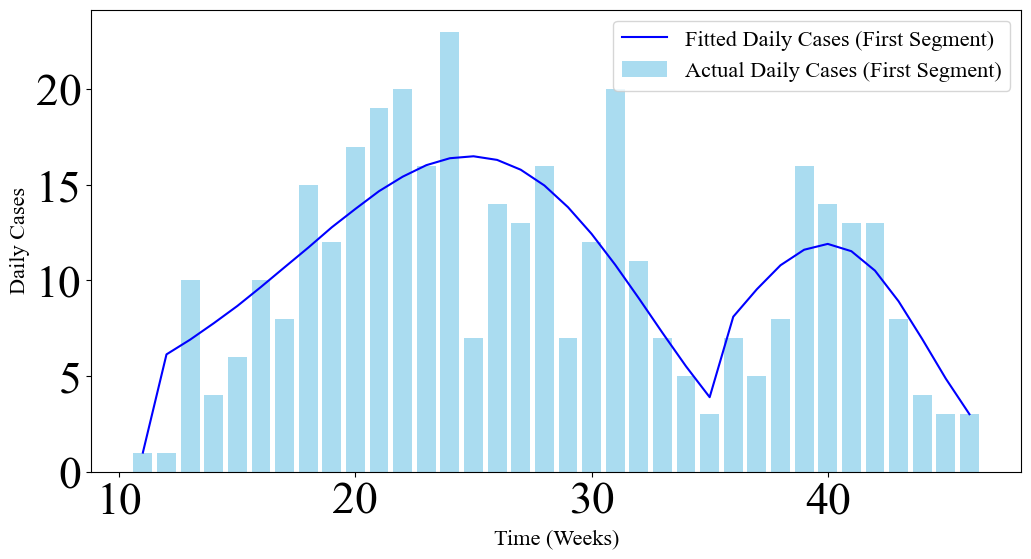

皮尔森相关系数：0.7739306038052267
p值：3.094477733973113e-08


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(11, 47), observed_cases_2023, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(11, 47), result_2023, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../outcome/Figure/Fit/Chuzhou/2023.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2023, result_2023)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

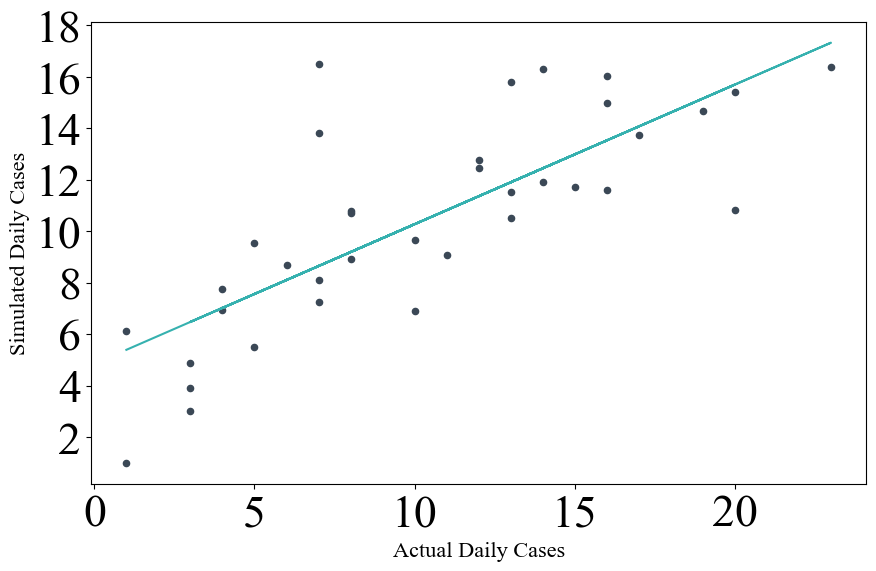

R²：0.5989685795063227


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  # 导入 MaxNLocator

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2023)
predicted_cases = np.array(result_2023)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()
# 设置 y 轴刻度为整数
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../outcome/Figure/Goodness of fit/Chuzhou/2023.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

R_2023 的中位数: 2.1877513575771594
R_2023 的平均数为: 3.327333823193239


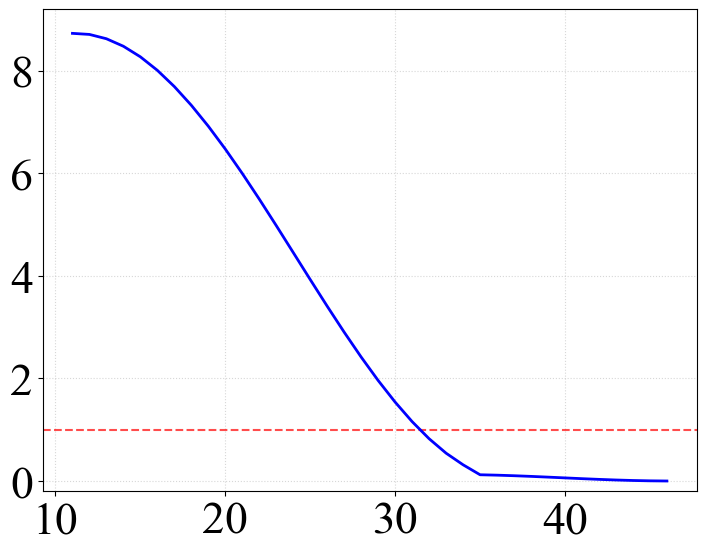

In [ ]:
R_2023 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2023).to_excel('../../outcome/Result/Fit/Chuzhou/R_2023.xlsx', index=False)

# 计算统计量
median_R_23 = statistics.median(R_2023)
print("R_2023 的中位数:", median_R_23)
average_R = np.mean(R_2023)
print(f"R_2023 的平均数为: {average_R}")

# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
plt.ylim(-0.2, 9.2)
plt.yticks(np.arange(0, 8.1, 2))  # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()

# 绘制数据
plt.plot(np.arange(11, 47), R_2023, 'b-', linewidth=2, label='Effective Reproduction Number')

plt.savefig('../../outcome/Figure/Fit/Chuzhou/R_2023.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

## 2022

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 116
    # data points      = 34
    # variables        = 4
    chi-square         = 557.953793
    reduced chi-square = 18.5984598
    Akaike info crit   = 103.129131
    Bayesian info crit = 109.234573
    R-squared          = 0.65957059
[[Variables]]
    beta0:  0.04909742 +/- 0.02990954 (60.92%) (init = 0.001)
    alpha:  2.50037412 +/- 5.27359501 (210.91%) (init = 2)
    T:      52 (fixed)
    S2_0:   99997.3297 +/- 106785.817 (106.79%) (init = 3000)
    S3_0:   1162.14748 +/- 9.6708e+09 (832146914.45%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta0, S2_0)  = -0.9890
    C(alpha, S3_0)  = +0.9686
    C(beta0, alpha) = -0.5363
    C(alpha, S2_0)  = +0.4828
    C(beta0, S3_0)  = -0.3859
    C(S2_0, S3_0)   = +0.3075
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 128
    # dat

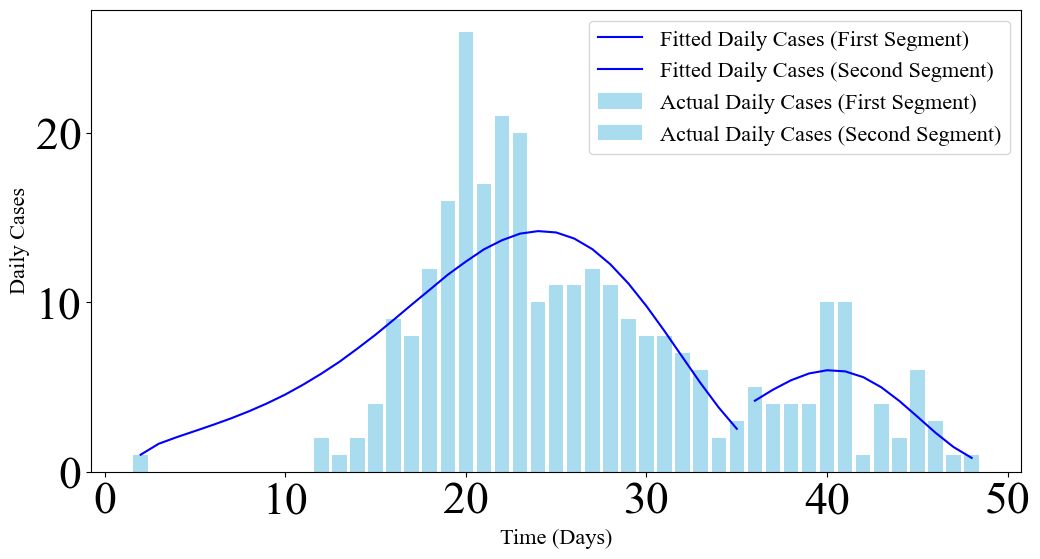

In [401]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters

# 定义 β 的季节性变化函数
def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))

# 定义 MMDM2 模型的微分方程
def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  # 人口总数
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  # 计算季节性β
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    # 微分方程
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  # 新发病例数

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]

# 提取每日新增病例数据
observed_cases_1 = I_2022[1:35].reset_index(drop=True).values  # 第一段数据
observed_cases_2 = I_2022[35:48].reset_index(drop=True).values  # 第二段数据
t_days_1 = np.arange(2, 36)  # 第一段48-236日
t_days_2 = np.arange(35, 49)  # 第二段拟合236-330日
t_days_3 = np.arange(36, 49)  # 画图用的第二段

# 定义模型包装函数，用于拟合数据
def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 4049999  # 直接代入初始值
    I1_0 = 1        # 直接代入初始值
    E1_0 = 0        # 直接代入初始值
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.00664
    dr1 = 0.00802
    κ = 1
    p = 0.043
    f = 0.0068493
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))

# 创建 lmfit 模型
model = Model(model_fit)

# 设置拟合参数及初始值和边界
params = Parameters()
params.add('beta0', value=0.001, min=0, max=1)  # β0 的范围设为 [0.01, 0.5]
params.add('alpha', value=2, min=-10, max=10)       # α 的范围设为 [-10, 10]
params.add('T', value=52, vary=False)               # T 固定为 52 周
params.add('S2_0', value=3000, min=1000, max=1e5)  # S2_0 的范围设为 [1000, 1e6]
params.add('S3_0', value=1000, min=1000, max=1e4)  # S3_0 的范围设为 [1000, 1e6]

# 使用 lmfit 进行拟合
result_1 = model.fit(observed_cases_1, params, t=t_days_1)

# 提取第一段拟合结果的最后状态，作为第二段的初始值
S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value

# 使用 MMDM_model 对第一段的各个仓室值进行求解
initial_state_segment1 = [
    4049999, 0, 0, 1, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.00664
dr1 = 0.00802
κ = 1
p = 0.043
f = 0.0068493
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))

# 提取第一段拟合结果的最后一个状态
final_state_segment1 = result_segment1.y[:, -1]

# 第二段数据的拟合
def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.00664
    dr1 = 0.00802
    κ = 1
    p = 0.043
    f = 0.0068493
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt

# 创建第二段拟合模型
model_segment2 = Model(model_fit_segment2)

# 设置第二段拟合参数
params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=52)  # 用拟合的T效果比较好
# params_segment2.add('T', value=52, vary=False) 

# 使用 lmfit 进行第二段拟合
result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)

# 输出拟合报告
print(result_1.fit_report())
print(result_2.fit_report())

# 绘制第一段和第二段拟合结果
plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

R_2022 的中位数: 5.277477773958896
R_2022 的中位数: 0.026713544502427983


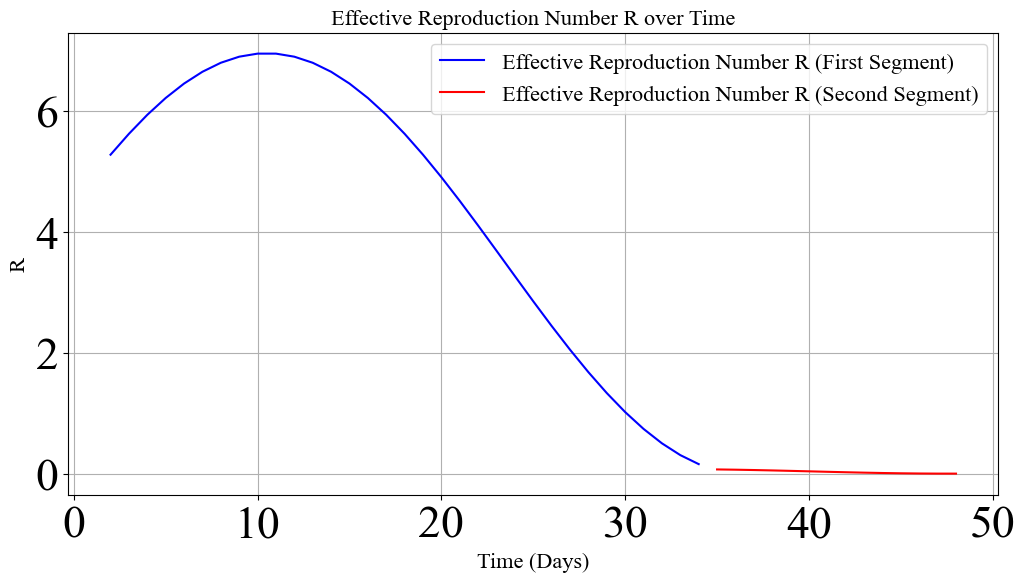

In [402]:
N1 = 4050000


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(2, 35)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics

# 如果 R_2022 是列表
median_R_1 = statistics.median(R_values_1)
median_R_2 = statistics.median(R_values_2)
print("R_2022 的中位数:", median_R_1)
print("R_2022 的中位数:", median_R_2)

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2022 = np.concatenate((result_1.best_fit, result_2.best_fit))

# 提取 I_2022[47:329] 的数据
observed_cases_2022 = I_2022[1:48].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2022# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2022  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# 计算MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')

# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 13.451158886521954
RMSE: 3.667582158114792
R-squared: 0.6522283476085323
MAE: 2.7857935243090304
MAPE: inf%


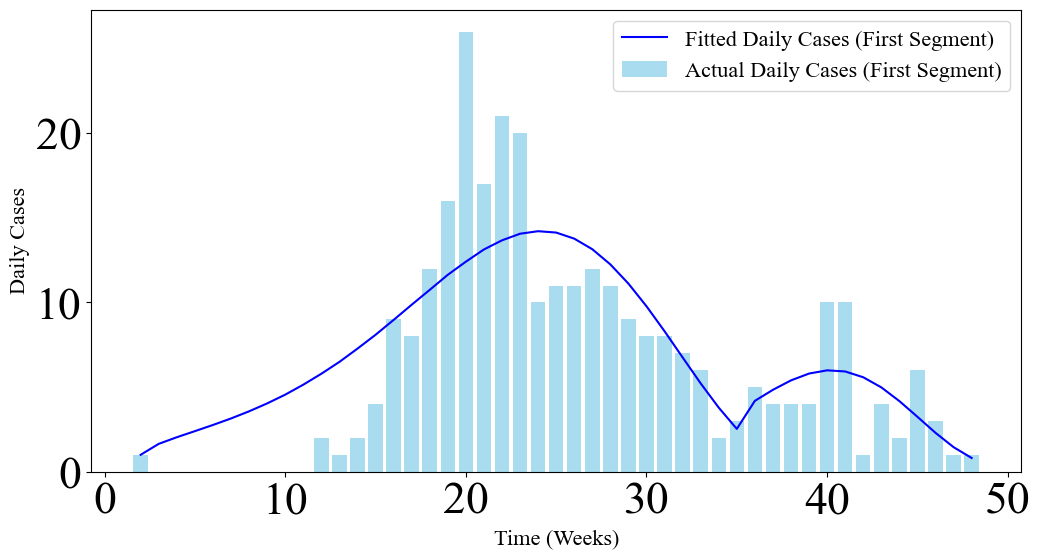

皮尔森相关系数：0.8316715362906891
p值：4.482864417713133e-13


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(2, 49), observed_cases_2022, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(2, 49), result_2022, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../outcome/Figure/Fit/Chuzhou/2022.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2022, result_2022)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

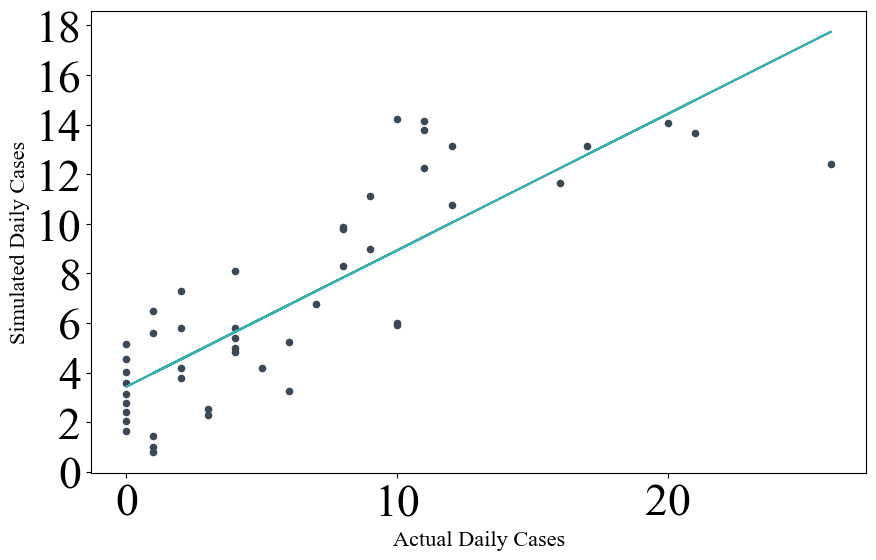

R²：0.6916775442761149


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  # 导入 MaxNLocator

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2022)
predicted_cases = np.array(result_2022)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()
# 设置 y 轴刻度为整数
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../outcome/Figure/Goodness of fit/Chuzhou/2022.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

Rt_11 的中位数为: 2.850941184902526
R_2023 的平均数为: 3.1401660414378574


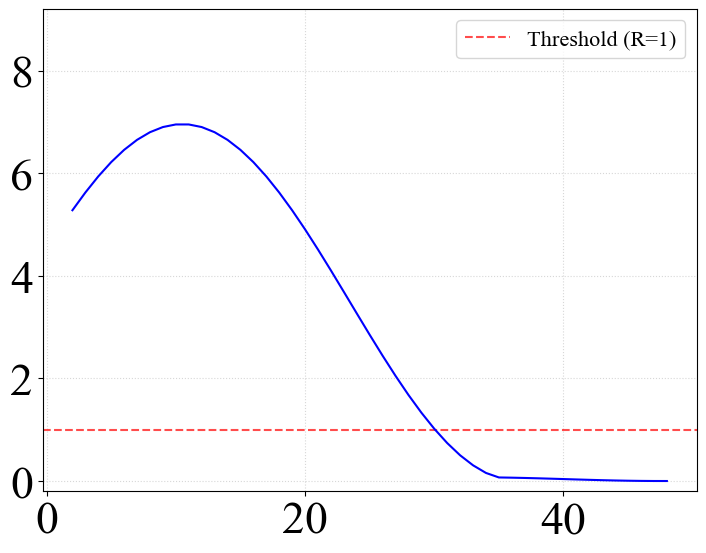

In [ ]:
R_2022 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2022).to_excel('../../outcome/Result/Fit/Chuzhou/R_2022.xlsx', index=False)

import statistics
# 计算Rt_11_values的中位数
median_Rt_11 = statistics.median(R_2022)
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2022)
print(f"R_2023 的平均数为: {average_R}")

# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
plt.ylim(-0.2, 9.2)
plt.yticks(np.arange(0, 8.1, 2))   # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()

plt.plot(np.arange(2, 49), R_2022, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
plt.legend()
# plt.ylim(-0.2, 4.2)
plt.savefig('../../outcome/Figure/Fit/Chuzhou/.pdf', format='pdf')
plt.show()

## 2021

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 74
    # data points      = 24
    # variables        = 4
    chi-square         = 307.098397
    reduced chi-square = 15.3549198
    Akaike info crit   = 69.1787450
    Bayesian info crit = 73.8909603
    R-squared          = 0.35460932
[[Variables]]
    beta0:  0.04036488 +/- 0.04981772 (123.42%) (init = 0.001)
    alpha:  2.52736946 +/- 7.20229258 (284.97%) (init = 2)
    T:      52 (fixed)
    S2_0:   99661.7758 +/- 329581.751 (330.70%) (init = 3000)
    S3_0:   2059.56547 +/- 1.4690e+10 (713256850.30%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta0, S2_0) = -0.9939
    C(alpha, S3_0) = +0.9528
    C(S2_0, S3_0)  = -0.2450
    C(beta0, S3_0) = +0.1779
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 157
    # data points      = 11
    # variables        = 3
    chi-square    

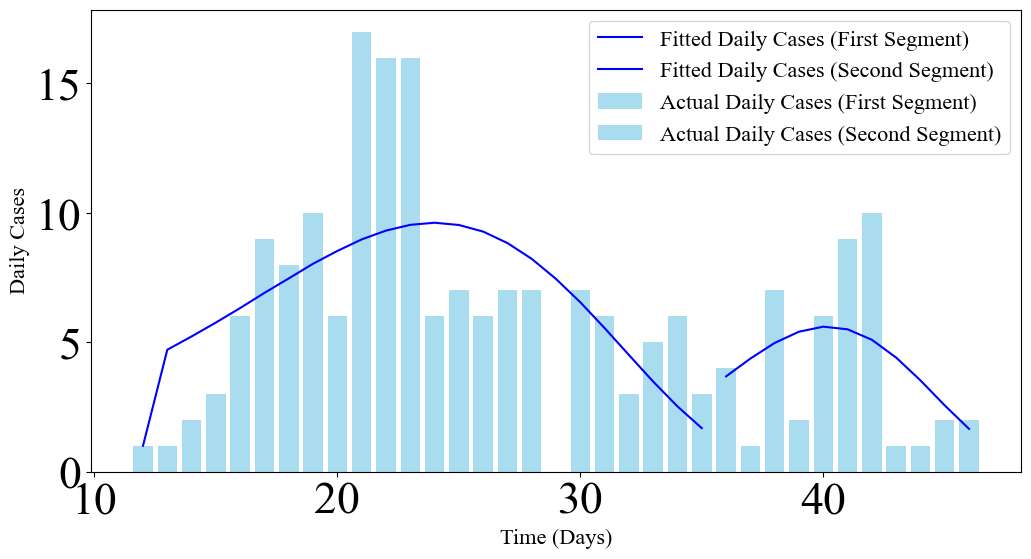

In [409]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters

# 定义 β 的季节性变化函数
def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))

# 定义 MMDM2 模型的微分方程
def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  # 人口总数
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  # 计算季节性β
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    # 微分方程
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  # 新发病例数

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]

# 提取每日新增病例数据
observed_cases_1 = I_2021[11:35].reset_index(drop=True).values  # 第一段数据
observed_cases_2 = I_2021[35:46].reset_index(drop=True).values  # 第二段数据
t_days_1 = np.arange(12, 36)  # 第一段48-236日
t_days_2 = np.arange(35, 47)  # 第二段拟合236-330日
t_days_3 = np.arange(36, 47)  # 画图用的第二段

# 定义模型包装函数，用于拟合数据
def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 3989999  # 直接代入初始值
    I1_0 = 1        # 直接代入初始值
    E1_0 = 0        # 直接代入初始值
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.00749
    dr1 = 0.00792
    κ = 1
    p = 0.043
    f = 0
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))

# 创建 lmfit 模型
model = Model(model_fit)

# 设置拟合参数及初始值和边界
params = Parameters()
params.add('beta0', value=0.001, min=0, max=1)  # β0 的范围设为 [0.01, 0.5]
params.add('alpha', value=2, min=-10, max=10)       # α 的范围设为 [-10, 10]
params.add('T', value=52, vary=False)               # T 固定为 52 周
params.add('S2_0', value=3000, min=1000, max=1e5)  # S2_0 的范围设为 [1000, 1e6]
params.add('S3_0', value=1000, min=1000, max=1e4)  # S3_0 的范围设为 [1000, 1e6]


# 使用 lmfit 进行拟合
result_1 = model.fit(observed_cases_1, params, t=t_days_1)

# 提取第一段拟合结果的最后状态，作为第二段的初始值
S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value

# 使用 MMDM_model 对第一段的各个仓室值进行求解
initial_state_segment1 = [
    3989999, 0, 0, 1, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.00749
dr1 = 0.00792
κ = 1
p = 0.043
f = 0
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))

# 提取第一段拟合结果的最后一个状态
final_state_segment1 = result_segment1.y[:, -1]

# 第二段数据的拟合
def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.00749
    dr1 = 0.00792
    κ = 1
    p = 0.043
    f = 0
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt

# 创建第二段拟合模型
model_segment2 = Model(model_fit_segment2)

# 设置第二段拟合参数
params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=52)  # 用拟合的T效果比较好
# params_segment2.add('T', value=52, vary=False) 

# 使用 lmfit 进行第二段拟合
result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)

# 输出拟合报告
print(result_1.fit_report())
print(result_2.fit_report())

# 绘制第一段和第二段拟合结果
plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

R_2021 的中位数: 4.0775018883077765
R_2021 的中位数: 0.04496017570019707


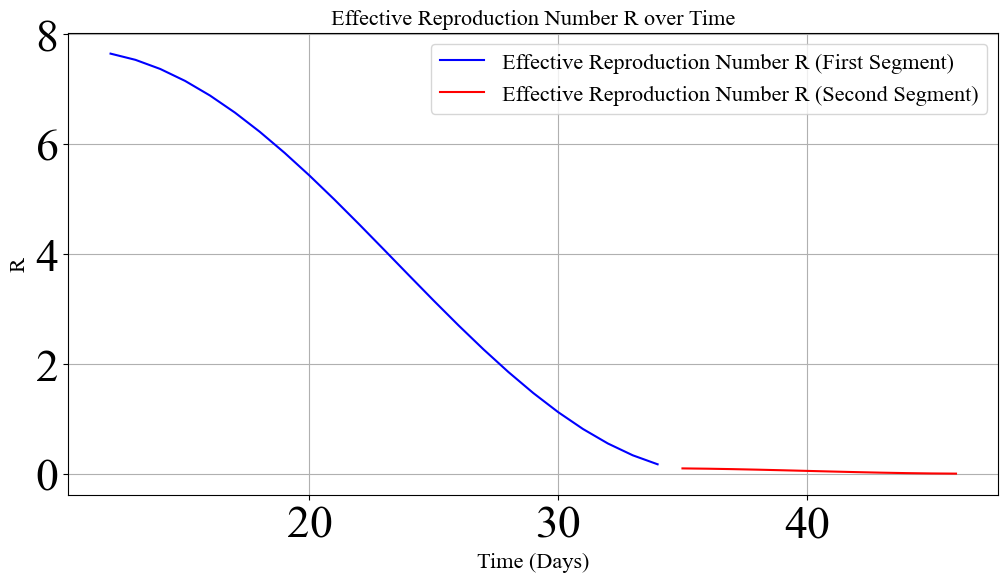

In [410]:
N1 = 3990000


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(12, 35)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics

# 如果 R_2023 是列表
median_R_1 = statistics.median(R_values_1)
median_R_2 = statistics.median(R_values_2)
print("R_2021 的中位数:", median_R_1)
print("R_2021 的中位数:", median_R_2)

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2021 = np.concatenate((result_1.best_fit, result_2.best_fit))

# 提取 I_2023[47:329] 的数据
observed_cases_2021 = I_2021[11:46].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2021# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2021  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# 计算MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')

# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 11.118316735657276
RMSE: 3.3344140018385953
R-squared: 0.3877578890056568
MAE: 2.621171484043281
MAPE: inf%


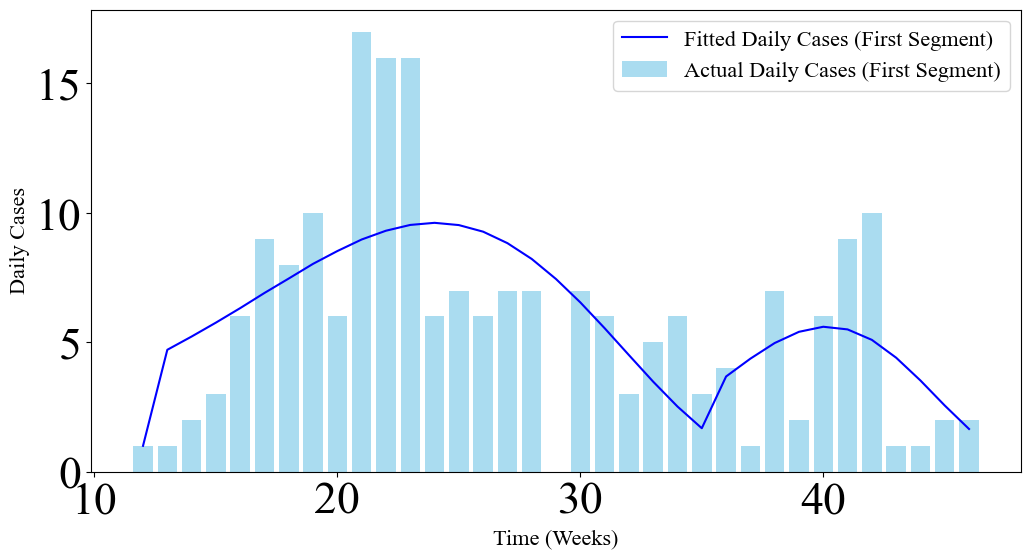

皮尔森相关系数：0.6245431225223208
p值：6.073592677737541e-05


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(12, 47), observed_cases_2021, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(12, 47), result_2021, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../outcome/Figure/Fit/Chuzhou/2021.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2021, result_2021)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

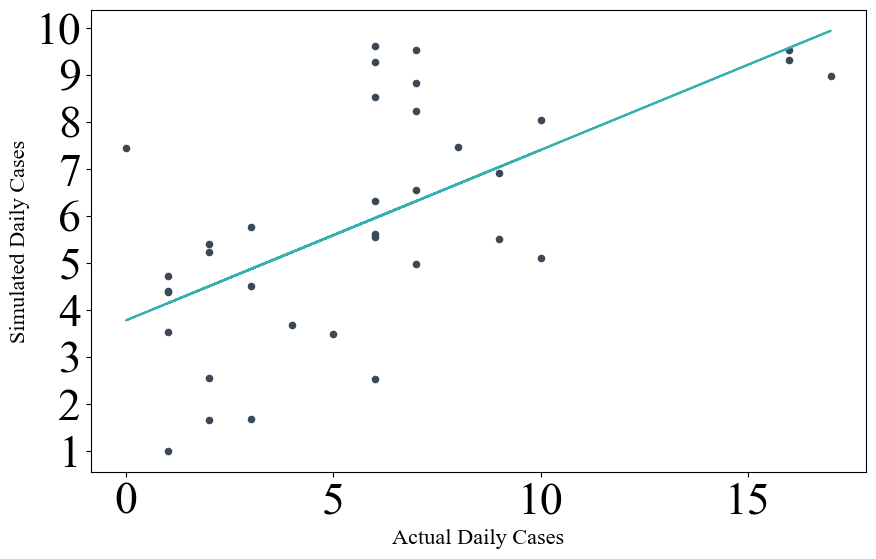

R²：0.39005411188993055


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  # 导入 MaxNLocator

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2021)
predicted_cases = np.array(result_2021)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()
# 设置 y 轴刻度为整数
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../outcome/Figure/Goodness of fit/Chuzhou/2021.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

Rt_11 的中位数为: 1.4684155046622112
R_2023 的平均数为: 2.65319499551475


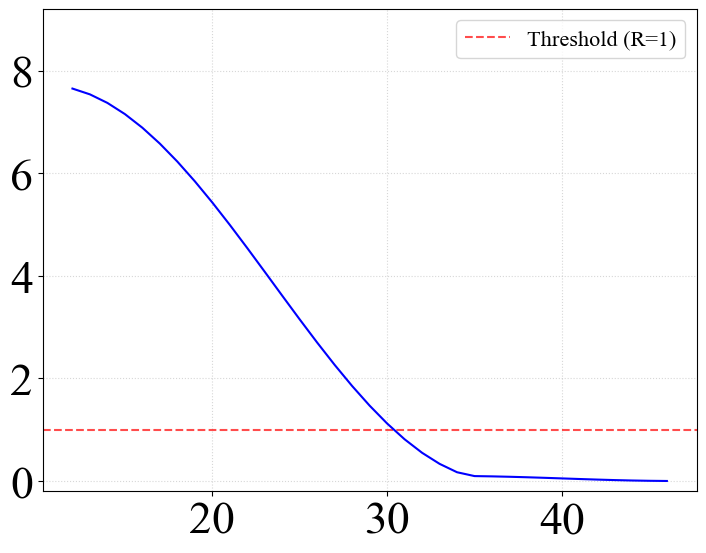

In [ ]:
R_2021 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2021).to_excel('../../outcome/Result/Fit/Chuzhou/R_2021.xlsx', index=False)

import statistics
# 计算Rt_11_values的中位数
median_Rt_11 = statistics.median(R_2021)
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2021)
print(f"R_2023 的平均数为: {average_R}")
# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
plt.ylim(-0.2, 9.2)
plt.yticks(np.arange(0, 8.1, 2))  # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()

plt.plot(np.arange(12, 47), R_2021, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
plt.legend()
# plt.ylim(-0.2, 4.2)
plt.savefig('../../outcome/Figure/Fit/Chuzhou/R_2021.pdf', format='pdf')
plt.show()

## 2020

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 154
    # data points      = 21
    # variables        = 4
    chi-square         = 211.092608
    reduced chi-square = 12.4172122
    Akaike info crit   = 56.4632645
    Bayesian info crit = 60.6413542
    R-squared          = 0.28500891
[[Variables]]
    beta0:  0.06523331 +/- 0.05139016 (78.78%) (init = 0.001)
    alpha:  0.30889898 +/- 14.7678267 (4780.79%) (init = 2)
    T:      52 (fixed)
    S2_0:   24071.2102 +/- 57889.5699 (240.49%) (init = 3000)
    S3_0:   1000.00359 +/- 191767.872 (19176.72%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha, S3_0)  = -0.9773
    C(beta0, S2_0)  = -0.9144
    C(beta0, alpha) = -0.6227
    C(beta0, S3_0)  = +0.4711
    C(alpha, S2_0)  = +0.2860
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 161
    # data points      = 12
    # variable

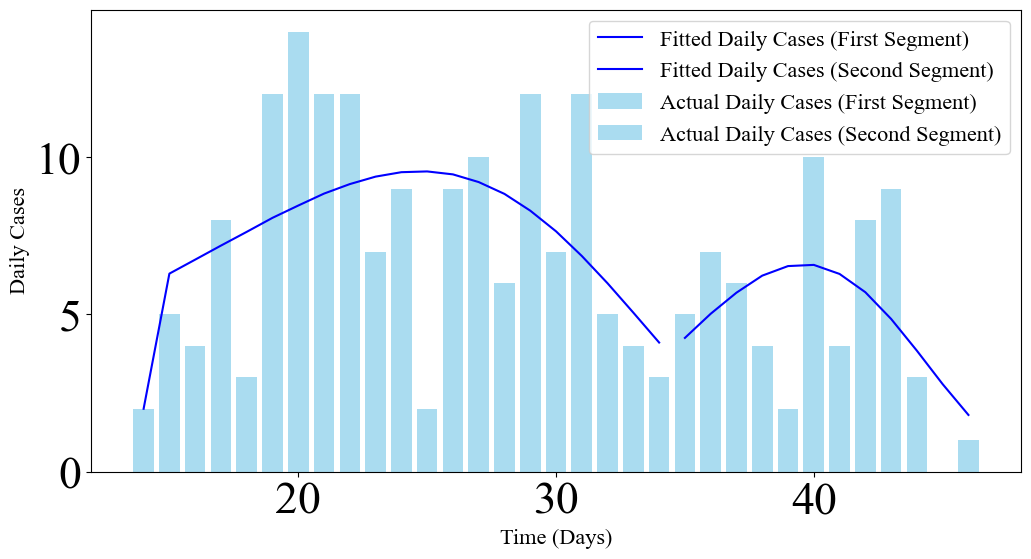

In [418]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters

# 定义 β 的季节性变化函数
def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))

# 定义 MMDM2 模型的微分方程
def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  # 人口总数
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  # 计算季节性β
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    # 微分方程
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  # 新发病例数

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]

# 提取每日新增病例数据
observed_cases_1 = I_2020[13:34].reset_index(drop=True).values  # 第一段数据
observed_cases_2 = I_2020[34:46].reset_index(drop=True).values  # 第二段数据
t_days_1 = np.arange(14, 35)  # 第一段48-236日
t_days_2 = np.arange(34, 47)  # 第二段拟合236-330日
t_days_3 = np.arange(35, 47)  # 画图用的第二段

# 定义模型包装函数，用于拟合数据
def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 3988499  # 直接代入初始值
    I1_0 = 1        # 直接代入初始值
    E1_0 = 0        # 直接代入初始值
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.0119
    dr1 = 0.0062
    κ = 1
    p = 0.043
    f = 0.013825
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))

# 创建 lmfit 模型
model = Model(model_fit)

# 设置拟合参数及初始值和边界
params = Parameters()
params.add('beta0', value=0.001, min=0, max=1)  # β0 的范围设为 [0.01, 0.5]
params.add('alpha', value=2, min=-10, max=10)       # α 的范围设为 [-10, 10]
params.add('T', value=52, vary=False)               # T 固定为 52 周
params.add('S2_0', value=3000, min=1000, max=1e5)  # S2_0 的范围设为 [1000, 1e6]
params.add('S3_0', value=1000, min=1000, max=1e4)  # S3_0 的范围设为 [1000, 1e6]

# 使用 lmfit 进行拟合
result_1 = model.fit(observed_cases_1, params, t=t_days_1)

# 提取第一段拟合结果的最后状态，作为第二段的初始值
S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value

# 使用 MMDM_model 对第一段的各个仓室值进行求解
initial_state_segment1 = [
    3988499, 0, 0, 1, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.0119
dr1 = 0.0062
κ = 1
p = 0.043
f = 0.013825
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))

# 提取第一段拟合结果的最后一个状态
final_state_segment1 = result_segment1.y[:, -1]

# 第二段数据的拟合
def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.0119
    dr1 = 0.0062
    κ = 1
    p = 0.043
    f = 0.013825
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt

# 创建第二段拟合模型
model_segment2 = Model(model_fit_segment2)

# 设置第二段拟合参数
params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=52)  # 用拟合的T效果比较好
# params_segment2.add('T', value=52, vary=False) 

# 使用 lmfit 进行第二段拟合
result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)

# 输出拟合报告
print(result_1.fit_report())
print(result_2.fit_report())

# 绘制第一段和第二段拟合结果
plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

R_2020 的中位数: 2.6933667179136416
R_2020 的中位数: 0.047754584455852116


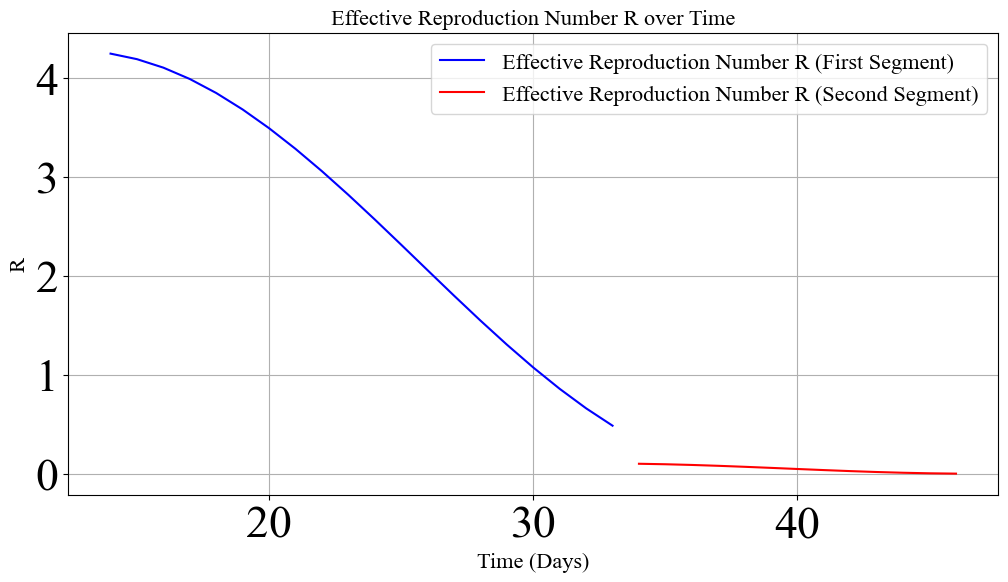

In [419]:
N1 = 3988500


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(14, 34)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics

# 如果 R_2023 是列表
median_R_1 = statistics.median(R_values_1)
median_R_2 = statistics.median(R_values_2)
print("R_2020 的中位数:", median_R_1)
print("R_2020 的中位数:", median_R_2)

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2020 = np.concatenate((result_1.best_fit, result_2.best_fit))

# 提取 I_2023[47:329] 的数据
observed_cases_2020 = I_2020[13:46].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2020# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2020  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# 计算MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')
# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 8.7796102609868
RMSE: 2.963040712002925
R-squared: 0.367491692629358
MAE: 2.3792117844247525
MAPE: inf%


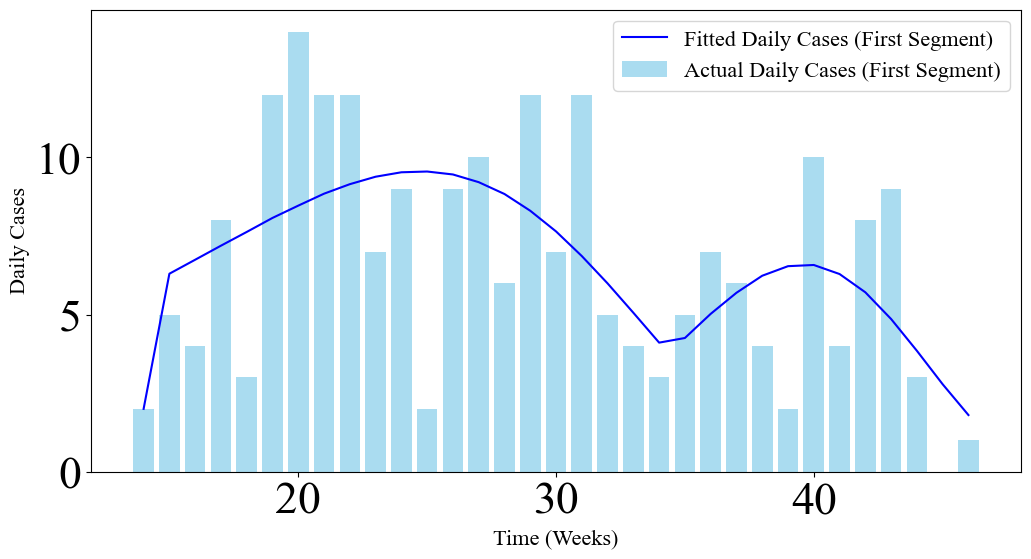

皮尔森相关系数：0.6067038117548371
p值：0.0001818060236930229


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(14, 47), observed_cases_2020, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(14, 47), result_2020, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../outcome/Figure/Fit/Chuzhou/2020.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2020, result_2020)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

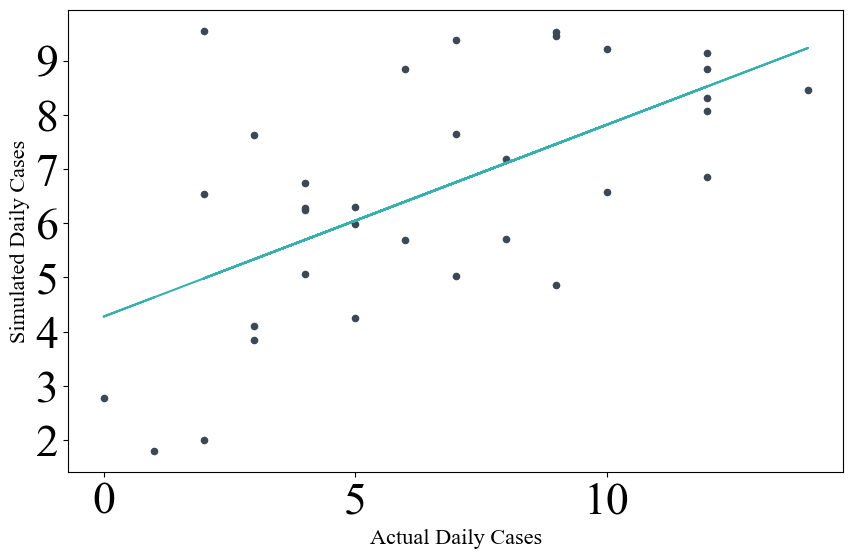

R²：0.3680895151978487


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  # 导入 MaxNLocator

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2020)
predicted_cases = np.array(result_2020)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()
# 设置 y 轴刻度为整数
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../outcome/Figure/Goodness of fit/Chuzhou/2020.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

Rt_11 的中位数为: 1.073250899946251
R_2023 的平均数为: 1.5758116224380785


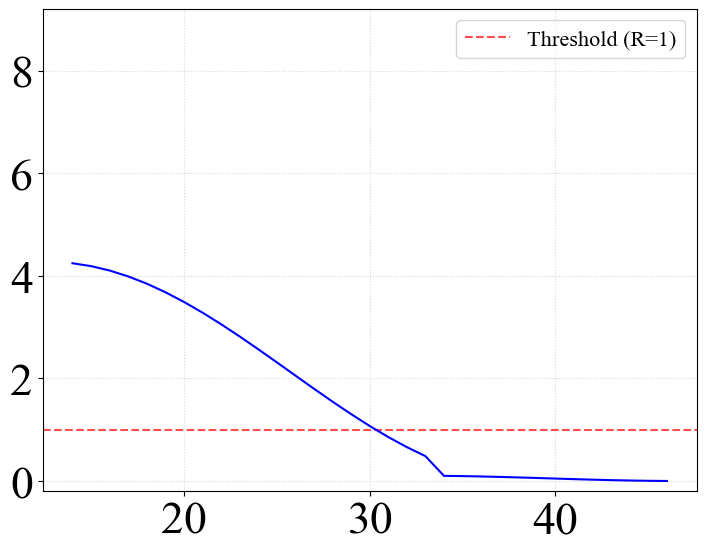

In [ ]:
R_2020 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2020).to_excel('../../outcome/Result/Fit/Chuzhou/R_2020.xlsx', index=False)

import statistics
# 计算Rt_11_values的中位数
median_Rt_11 = statistics.median(R_2020)
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2020)
print(f"R_2023 的平均数为: {average_R}")

# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
plt.ylim(-0.2, 9.2)
plt.yticks(np.arange(0, 8.1, 2))  # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()

plt.plot(np.arange(14, 47), R_2020, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
plt.legend()
# plt.ylim(-0.2, 4.2)
plt.savefig('../../outcome/Figure/Fit/Chuzhou/R_2020.pdf', format='pdf')
plt.show()

## 2019

[[Model]]
    Model(model_fit)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 54
    # data points      = 24
    # variables        = 4
    chi-square         = 70.7207184
    reduced chi-square = 3.53603592
    Akaike info crit   = 33.9364339
    Bayesian info crit = 38.6486492
    R-squared          = 0.33045474
[[Variables]]
    beta0:  0.02733338 +/- 0.02890853 (105.76%) (init = 0.001)
    alpha:  0.53417658 +/- 6.34336198 (1187.50%) (init = 2)
    T:      52 (fixed)
    S2_0:   95148.0860 +/- 279454.170 (293.70%) (init = 3000)
    S3_0:   1015.10005 +/- 1.0918e+10 (1075522556.96%) (init = 1000)
[[Correlations]] (unreported correlations are < 0.100)
    C(beta0, S2_0) = -0.9866
    C(alpha, S3_0) = +0.9480
    C(S2_0, S3_0)  = -0.4025
    C(beta0, S3_0) = +0.2742
    C(alpha, S2_0) = -0.1371
[[Model]]
    Model(model_fit_segment2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 155
    # data points      = 11
    # variable

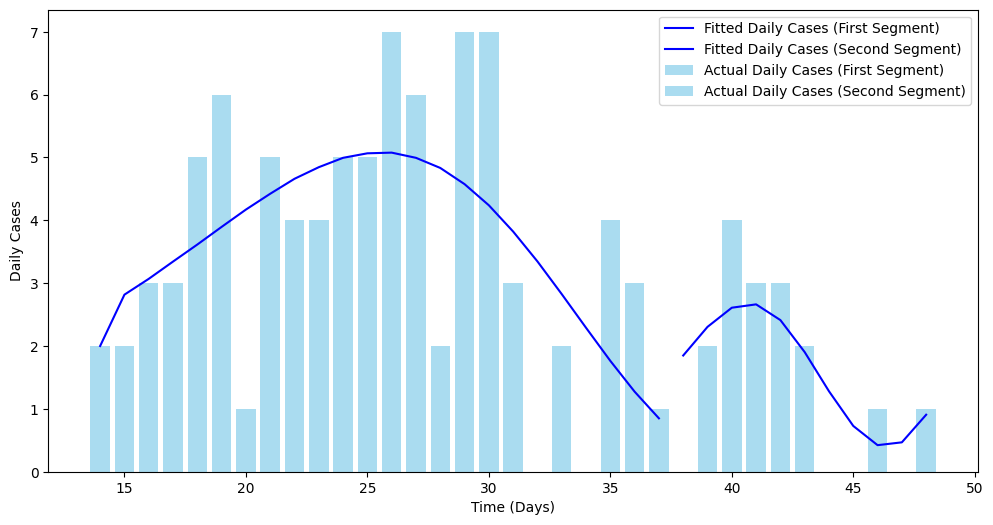

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from lmfit import Model, Parameters

# 定义 β 的季节性变化函数
def beta_seasonal(t, beta0, alpha, T):
    return beta0 * (1 + np.sin(2 * np.pi * (t + alpha) / T))

# 定义 MMDM2 模型的微分方程
def MMDM2_model(t, Y, beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3):
    S1, E1, A1, I1, R1, S2, E2, A2, S3, E3, A3, X = Y

    N1 = S1 + E1 + A1 + I1 + R1  # 人口总数
    N2 = S2 + E2 + A2
    N3 = S3 + E3 + A3

    β1 = beta_seasonal(t, beta0, alpha, T)  # 计算季节性β
    β21 = 8 * β1
    β23 = 8 * β1
    β31 = 2 * β1
    β32 = 8 * β1

    # 微分方程
    dS1_dt = br1 * N1 - dr1 * S1 - β1 * S1 * (I1 + κ * A1) / N1 - β21 * S1 * A2 / N1 - β31 * S1 * A3 / N1
    dE1_dt = β1 * S1 * (I1 + κ * A1) / N1 + β21 * S1 * A2 / N1 + β31 * S1 * A3 / N1 - dr1 * E1 - ω1 * E1
    dA1_dt = p * ω1 * E1 - dr1 * A1 - γ_prime * A1
    dI1_dt = (1 - p) * ω1 * E1 - γ * I1 - (dr1 + f) * I1
    dR1_dt = γ_prime * A1 + γ * I1 - dr1 * R1

    dS2_dt = br2 * N2 - dr2 * S2 - β32 * S2 * A3 / N1
    dE2_dt = β32 * S2 * A3 / N1 - ω2 * E2 - dr2 * E2
    dA2_dt = ω2 * E2 - dr2 * A2

    dS3_dt = br3 * N3 - dr3 * S3 - β23 * S3 * A2 / N1
    dE3_dt = β23 * S3 * A2 / N1 - ω3 * E3 - dr3 * E3
    dA3_dt = ω3 * E3 - dr3 * A3

    dX_dt = (1 - p) * ω1 * E1  # 新发病例数

    return [dS1_dt, dE1_dt, dA1_dt, dI1_dt, dR1_dt, dS2_dt, dE2_dt, dA2_dt, dS3_dt, dE3_dt, dA3_dt, dX_dt]

# 提取每日新增病例数据
observed_cases_1 = I_2019[13:37].reset_index(drop=True).values  # 第一段数据
observed_cases_2 = I_2019[37:48].reset_index(drop=True).values  # 第二段数据
t_days_1 = np.arange(14, 38)  # 第一段48-236日
t_days_2 = np.arange(37, 49)  # 第二段拟合236-330日
t_days_3 = np.arange(38, 49)  # 画图用的第二段

# 定义模型包装函数，用于拟合数据
def model_fit(t, beta0, alpha, T, S2_0, S3_0):
    S1_0 = 4146998  # 直接代入初始值
    I1_0 = 2        # 直接代入初始值
    E1_0 = 0        # 直接代入初始值
    initial_state = [
        S1_0, E1_0, 0, I1_0, 0, S2_0, 0, 1, S3_0, 0, 10, 0
    ]
    br1 = 0.0119
    dr1 = 0.0062
    κ = 1
    p = 0.043
    f = 0.029126
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12

    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    X_values = result.y[11].flatten()
    dX_dt = np.diff(X_values)
    return np.concatenate(([observed_cases_1[0]], dX_dt))

# 创建 lmfit 模型
model = Model(model_fit)

# 设置拟合参数及初始值和边界
params = Parameters()
params.add('beta0', value=0.001, min=0, max=1)  # β0 的范围设为 [0.01, 0.5]
params.add('alpha', value=2, min=-10, max=10)       # α 的范围设为 [-10, 10]
params.add('T', value=52, vary=False)               # T 固定为 52 周
params.add('S2_0', value=3000, min=1000, max=1e5)  # S2_0 的范围设为 [1000, 1e6]
params.add('S3_0', value=1000, min=1000, max=1e4)  # S3_0 的范围设为 [1000, 1e6]

# 使用 lmfit 进行拟合
result_1 = model.fit(observed_cases_1, params, t=t_days_1)

# 提取第一段拟合结果的最后状态，作为第二段的初始值
S2_0_fit = result_1.params['S2_0'].value
S3_0_fit = result_1.params['S3_0'].value
beta0_fit = result_1.params['beta0'].value
alpha_fit = result_1.params['alpha'].value
T_fit = result_1.params['T'].value

# 使用 MMDM_model 对第一段的各个仓室值进行求解
initial_state_segment1 = [
    4146998, 0, 0, 2, 0, S2_0_fit, 0, 1, S3_0_fit, 0, 10, 0
]
br1 = 0.0119
dr1 = 0.0062
κ = 1
p = 0.043
f = 0.029126
ω1 = 7 / 11
γ = 7 / 14
γ_prime = 7 / 14
br2 = 0.17321
dr2 = 0.01155
br3 = 0.04619
dr3 = 0.00231
ω2 = 1
ω3 = 7 / 12

result_segment1 = solve_ivp(MMDM2_model, (0, max(t_days_1)), initial_state_segment1, t_eval=t_days_1,
                            args=(beta0_fit, alpha_fit, T_fit, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))

# 提取第一段拟合结果的最后一个状态
final_state_segment1 = result_segment1.y[:, -1]

# 第二段数据的拟合
def model_fit_segment2(t, beta0, alpha, T):
    initial_state = final_state_segment1
    
    br1 = 0.0119
    dr1 = 0.0062
    κ = 1
    p = 0.043
    f = 0.029126
    ω1 = 7 / 11
    γ = 7 / 14
    γ_prime = 7 / 14
    br2 = 0.17321
    dr2 = 0.01155
    br3 = 0.04619
    dr3 = 0.00231
    ω2 = 1
    ω3 = 7 / 12
    
    result = solve_ivp(MMDM2_model, (0, max(t)), initial_state, t_eval=t,
                       args=(beta0, alpha, T, br1, dr1, κ, p, f, ω1, γ, γ_prime, br2, dr2, br3, dr3, ω2, ω3))
    
    dX_dt = np.diff(result.y[11])
    return dX_dt

# 创建第二段拟合模型
model_segment2 = Model(model_fit_segment2)

# 设置第二段拟合参数
params_segment2 = Parameters()
params_segment2.add('beta0', value=1e-6, min=0, max=1)
params_segment2.add('alpha', value=2, min=0, max=36) 
params_segment2.add('T', value=25, min=1, max=52)  # 用拟合的T效果比较好
# params_segment2.add('T', value=52, vary=False) 

# 使用 lmfit 进行第二段拟合
result_2 = model_segment2.fit(observed_cases_2, params_segment2, t=t_days_2)

# 输出拟合报告
print(result_1.fit_report())
print(result_2.fit_report())

# 绘制第一段和第二段拟合结果
plt.figure(figsize=(12, 6))
plt.bar(t_days_1, observed_cases_1, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(t_days_1, result_1.best_fit, 'b-', label='Fitted Daily Cases (First Segment)')
plt.bar(t_days_3, observed_cases_2, color='skyblue', label='Actual Daily Cases (Second Segment)', alpha=0.7)
plt.plot(t_days_3, result_2.best_fit, 'b-', label='Fitted Daily Cases (Second Segment)')
plt.xlabel('Time (Days)')
plt.ylabel('Daily Cases')
plt.legend()
plt.show()

R_2023 的中位数: 1.8209062184525397
R_2023 的中位数: 0.01528864479202645
R_2023 的均数: 1.7926168331880443


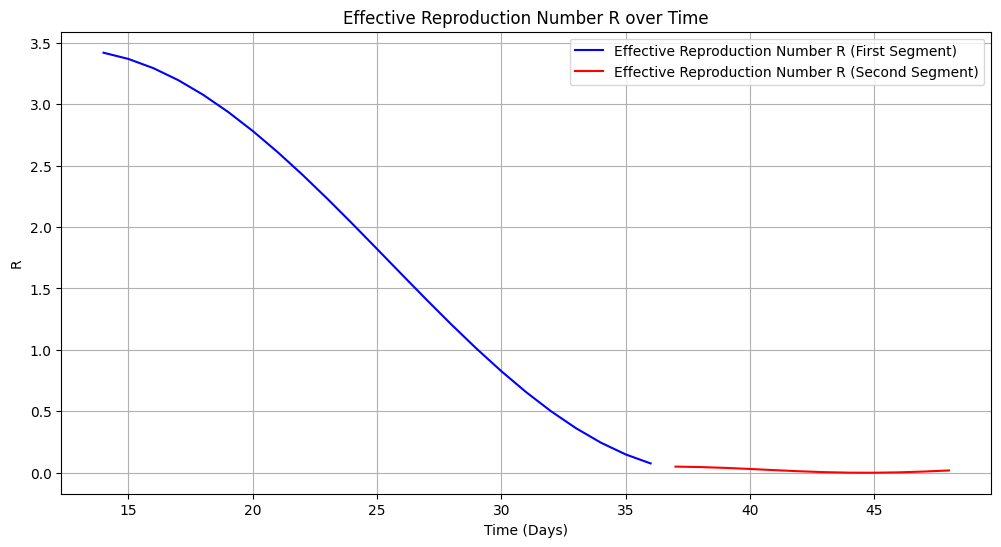

In [9]:
N1 = 4147000


# 定义有效再生数 R 的计算函数
def effective_reproduction_number(t, beta0, alpha, T, N1, N2, N3):
    beta1_val = beta_seasonal(t, beta0, alpha, T)
    beta23_val = 8 * beta1_val
    beta32_val = 8 * beta1_val
    
    # 将大整数转换为浮点数
    large_num1 = 4203447335402825485147570440554598484865217155777042051211710155.0
    large_num2 = 3897787739929702299663151799028731409.0
    
    # 计算各项
    term1 = (151898626502622930683210950913780875264.0 * beta1_val) / 108450253910873811604665740691393562975.0
    term2 = -(200000000.0 * np.sqrt(large_num1) * np.sqrt(N2 * N3 * beta23_val * beta32_val)) / (large_num2 * N1)
    term3 = -term2
    
    # 计算 R
    R = max([0, term1, term2, term3])
    
    return R
t_days_1 = np.arange(14, 37)
# 计算 R 随时间的变化（分段）
R_values_1 = [effective_reproduction_number(ti, result_1.params['beta0'].value, result_1.params['alpha'].value, result_1.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_1]  # 第一段
R_values_2 = [effective_reproduction_number(ti, result_2.params['beta0'].value, result_2.params['alpha'].value, result_2.params['T'].value, N1, result_1.params['S2_0'].value, result_1.params['S3_0'].value) for ti in t_days_2]  # 第二段

import statistics

# 如果 R_2023 是列表
median_R_1 = statistics.median(R_values_1)
median_R_2 = statistics.median(R_values_2)
print("R_2023 的中位数:", median_R_1)
print("R_2023 的中位数:", median_R_2)
mean_R = np.mean(R_values_1)
print("R_2023 的均数:", mean_R)

# 绘制 R 随时间变化的图
plt.figure(figsize=(12, 6))
plt.plot(t_days_1, R_values_1, label='Effective Reproduction Number R (First Segment)', color='blue')
plt.plot(t_days_2, R_values_2, label='Effective Reproduction Number R (Second Segment)', color='red')
plt.xlabel('Time (Days)')
plt.ylabel('R')
plt.title('Effective Reproduction Number R over Time')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# 连接 result_1.best_fit 和 result_2.best_fit
result_2019 = np.concatenate((result_1.best_fit, result_2.best_fit))

# 提取 I_2023[47:329] 的数据
observed_cases_2019 = I_2019[13:48].reset_index(drop=True).values

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_true = observed_cases_2019# 这里是您给出的数据

# 假设模型的预测数据是：
y_pred = result_2019  

# 计算MSE，均方误差
mse = mean_squared_error(y_true, y_pred)
print(f'MSE: {mse}')

# 计算RMSE，均方根误差
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

# 计算R-squared
r2 = r2_score(y_true, y_pred)
print(f'R-squared: {r2}')

# 计算MAE
mae = mean_absolute_error(y_true, y_pred)
print(f'MAE: {mae}')

# 计算MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f'MAPE: {mape}%')
# 2) Pearson 相关及其 p 值
r, p = stats.pearsonr(y_true, y_pred)
print("Pearson p-value:", p)

MSE: 2.2675718664176525
RMSE: 1.5058458973008004
R-squared: 0.5097466402468012
MAE: 1.1457530234079074
MAPE: inf%


C:\Users\Irene\AppData\Local\Temp\ipykernel_100724\2005104237.py:31: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100


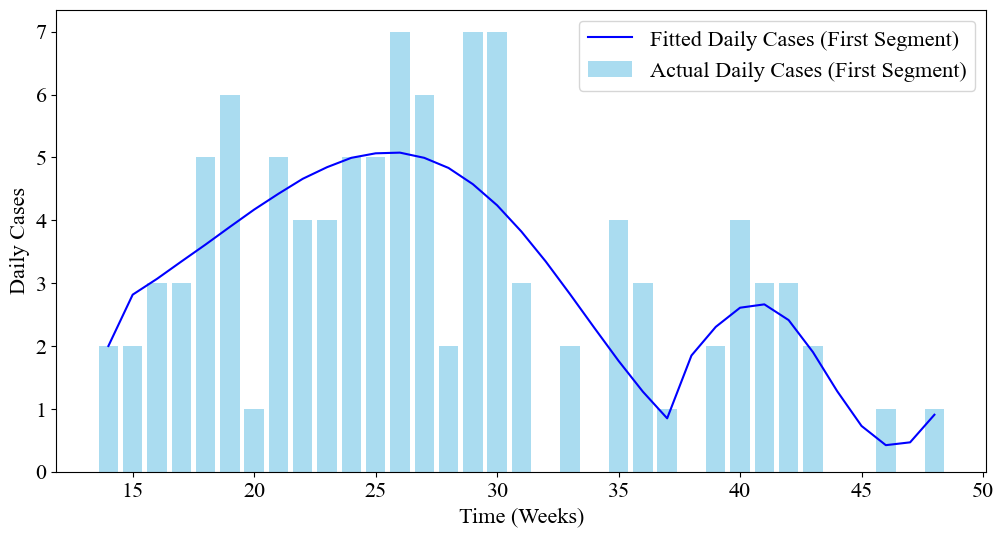

皮尔森相关系数：0.7149151669417072
p值：1.3996722035329773e-06


In [ ]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 16 
plt.figure(figsize=(12, 6))
plt.bar(np.arange(14, 49), observed_cases_2019, color='skyblue', label='Actual Daily Cases (First Segment)', alpha=0.7)
plt.plot(np.arange(14, 49), result_2019, 'b-', label='Fitted Daily Cases (First Segment)')
plt.xlabel('Time (Weeks)')
plt.ylabel('Daily Cases')
plt.legend()
# plt.ylim(-1, 31)
plt.savefig('../../outcome/Result/Fit/Chuzhou/20192.pdf', format='pdf')
plt.show()

# 计算相关系数
from scipy.stats import pearsonr

# 计算皮尔森相关系数和p值
corr, p_value = pearsonr(observed_cases_2019, result_2019)

print(f"皮尔森相关系数：{corr}")
print(f"p值：{p_value}")

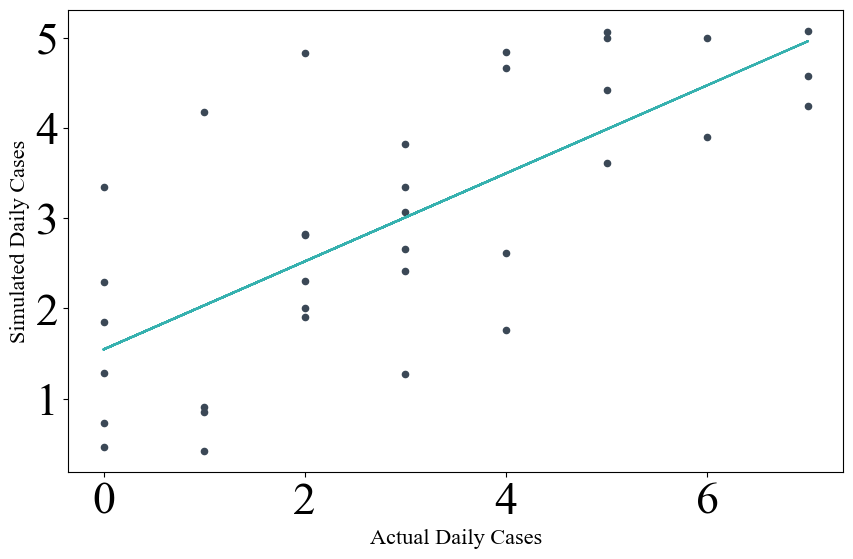

R²：0.5111036959232892


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from matplotlib.ticker import MaxNLocator  # 导入 MaxNLocator

# 确保I_obs和predicted_cases是numpy数组
I_obs = np.array(observed_cases_2019)
predicted_cases = np.array(result_2019)

# 创建线性回归模型
model = LinearRegression()

# 训练模型，需要将I_obs转换为二维数组
model.fit(I_obs.reshape(-1, 1), predicted_cases)

# 预测
y_pred = model.predict(I_obs.reshape(-1, 1))

# 计算R2值
r2 = r2_score(predicted_cases, y_pred)

# 绘制散点图和回归线
plt.rcParams['font.family'] = 'Times New Roman'
plt.figure(figsize=(10,6))
plt.scatter(I_obs, predicted_cases, facecolors='#3b4856', s=20)
plt.plot(I_obs, y_pred, color='#36b1af')
plt.xlabel('Actual Daily Cases')
plt.ylabel('Simulated Daily Cases')
# plt.legend()
# 设置 y 轴刻度为整数
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('../../outcome/Figure/Goodness of fit/Chuzhou/2019.pdf', bbox_inches='tight', dpi=300)
plt.show()

print(f"R²：{r2}")

Rt_11 的中位数为: 0.6551530424674863
R_2023 的平均数为: 1.1847947047538647


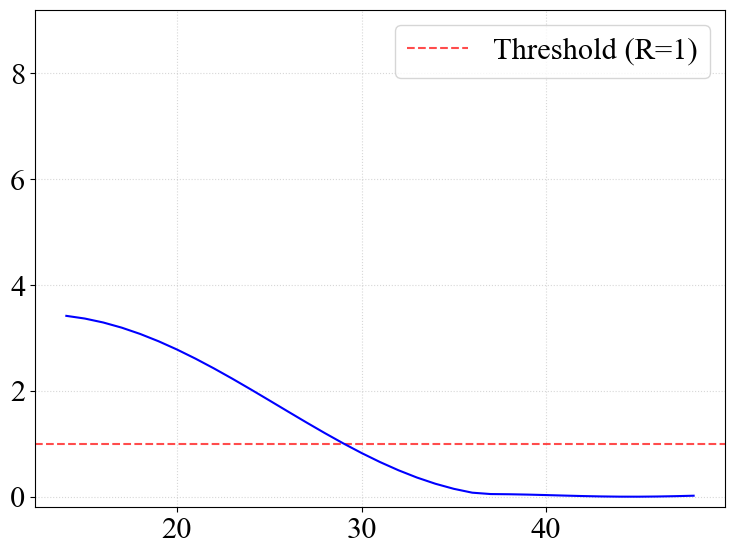

In [ ]:
R_2019 = np.concatenate((R_values_1, R_values_2))
pd.DataFrame(R_2019).to_excel('../../outcome/Result/Fit/Chuzhou/R_2019.xlsx', index=False)

import statistics
# 计算Rt_11_values的中位数
median_Rt_11 = statistics.median(R_2019)
print(f"Rt_11 的中位数为: {median_Rt_11}")
average_R = np.mean(R_2019)
print(f"R_2023 的平均数为: {average_R}")

# 设置全局字体
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 22 
# 创建图表
plt.figure(figsize=(8, 6))
plt.axhline(y=1, color='r', linestyle='--', linewidth=1.5, alpha=0.7, label='Threshold (R=1)')
# 坐标轴设置
plt.ylim(-0.2, 9.2)
plt.yticks(np.arange(0, 8.1, 2))  # 显式设置y轴刻度，步长为1（确保1可见）
plt.grid(True, linestyle=':', alpha=0.5)
# 保存和显示
plt.tight_layout()

plt.plot(np.arange(14, 49), R_2019, 'b-')
# plt.xlabel('Time (Weeks)')
# plt.ylabel('Effective Reproduction Number')
plt.legend()
# plt.ylim(-0.2, 4.2)
plt.savefig('../../outcome/Figure/Fit/Chuzhou/R_2019.pdf', format='pdf')
plt.show()